<a href="https://colab.research.google.com/github/mrScissors/cats-vs-dogs/blob/master/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os

Getting data from google drive

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

drive shareable link

In [4]:
link = 'https://drive.google.com/file/d/1ERDkoH0s260aOc0NvaNCQDpXW27zOcDY/view?usp=sharing'
id = '1ERDkoH0s260aOc0NvaNCQDpXW27zOcDY'

In [7]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dogs-vs-cats.zip')
zip = 'dogs-vs-cats.zip'

import zipfile

with zipfile.ZipFile(zip,"r") as z:
  z.extractall(".")

In [8]:
! ls

adc.json	  sample_data		test1.zip
dogs-vs-cats.zip  sampleSubmission.csv	train.zip


In [9]:
with zipfile.ZipFile('train.zip',"r") as z:
  z.extractall(".")

with zipfile.ZipFile('test1.zip',"r") as z:
  z.extractall(".")


In [10]:
! ls 

adc.json	  sample_data		test1	   train
dogs-vs-cats.zip  sampleSubmission.csv	test1.zip  train.zip


In [11]:
! rm dogs-vs-cats.zip test1.zip  train.zip

resizing parameters

In [12]:
FAST_RUN = False
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [13]:
# os.listdir('train')

Dataset prep

In [14]:
filenames = os.listdir('train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
df.head()

,filename,category
0,dog.10938.jpg,1
1,cat.2198.jpg,0
2,cat.8.jpg,0
3,dog.3270.jpg,1
4,cat.7675.jpg,0


Veiwing sample image

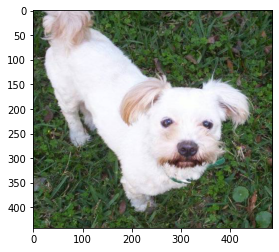

In [16]:
sample = random.choice(filenames)
image = load_img('train/'+sample)
plt.imshow(image)

Building model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)       



Early Stop

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)



Learning Rate Reduction

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]



In [20]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'}) 

In [21]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [22]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Traning Generator

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    'train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    'train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


Sample of generator

In [25]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    'train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


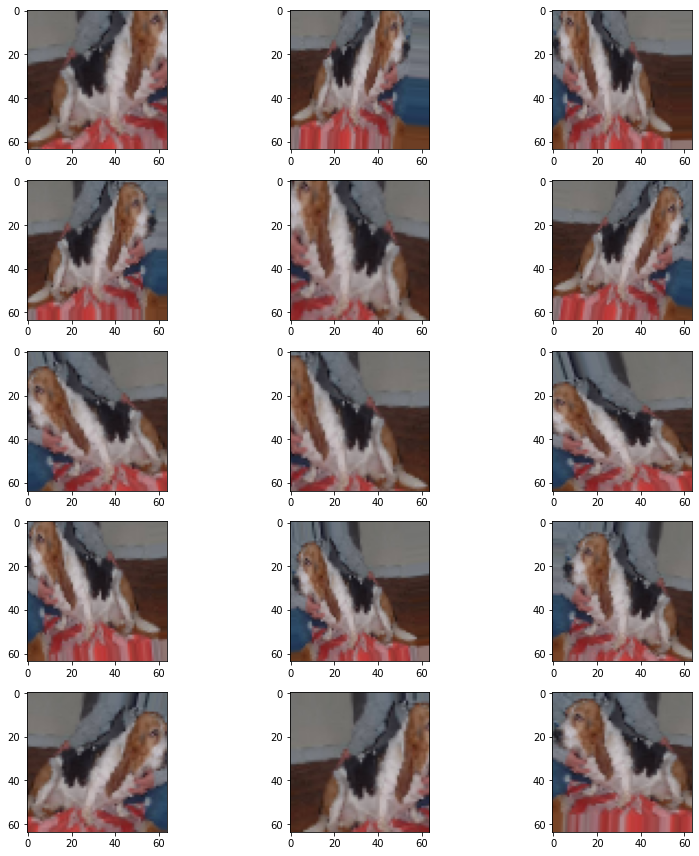

In [26]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

fitting to data

In [27]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1333/1333 [==============================] - 104s 78ms/step - loss: 0.7458 - accuracy: 0.6277 - val_loss: 0.5649 - val_accuracy: 0.7079 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 103s 77ms/step - loss: 0.5886 - accuracy: 0.6947 - val_loss: 0.5122 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 103s 77ms/step - loss: 0.5435 - accuracy: 0.7306 - val_loss: 0.5458 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - 106s 79ms/step - loss: 0.5130 - accuracy: 0.7548 - val_loss: 0.5007 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 106s 80ms/step - loss: 0.4953 - accuracy: 0.7619 - val_loss: 0.4860 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - 106s 79ms/step - loss: 0.4776 - accuracy: 0.7777 - val_loss: 0.4824 

KeyError: ignored

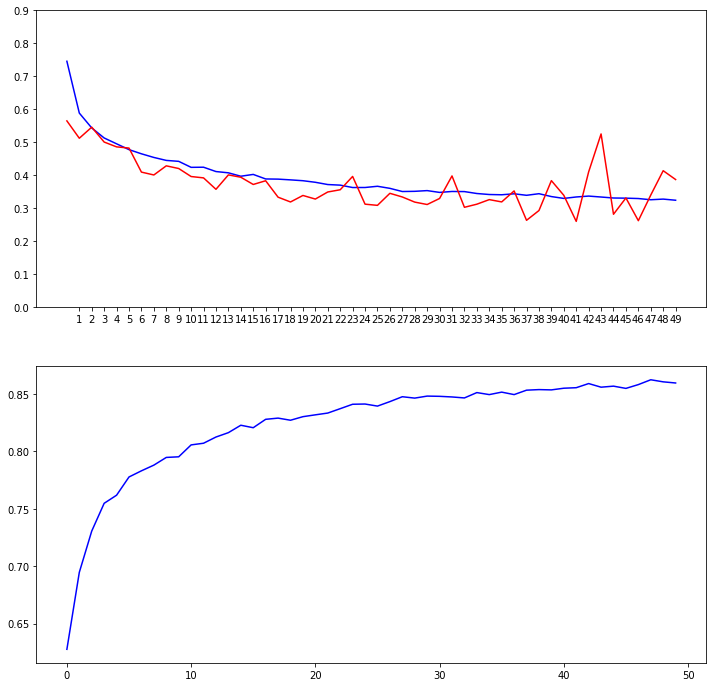

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Prepare Testing Data

In [30]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    'test1', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [33]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [34]:
test_df['category'] = np.argmax(predict, axis=-1)

In [35]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [36]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

See predicted label with images

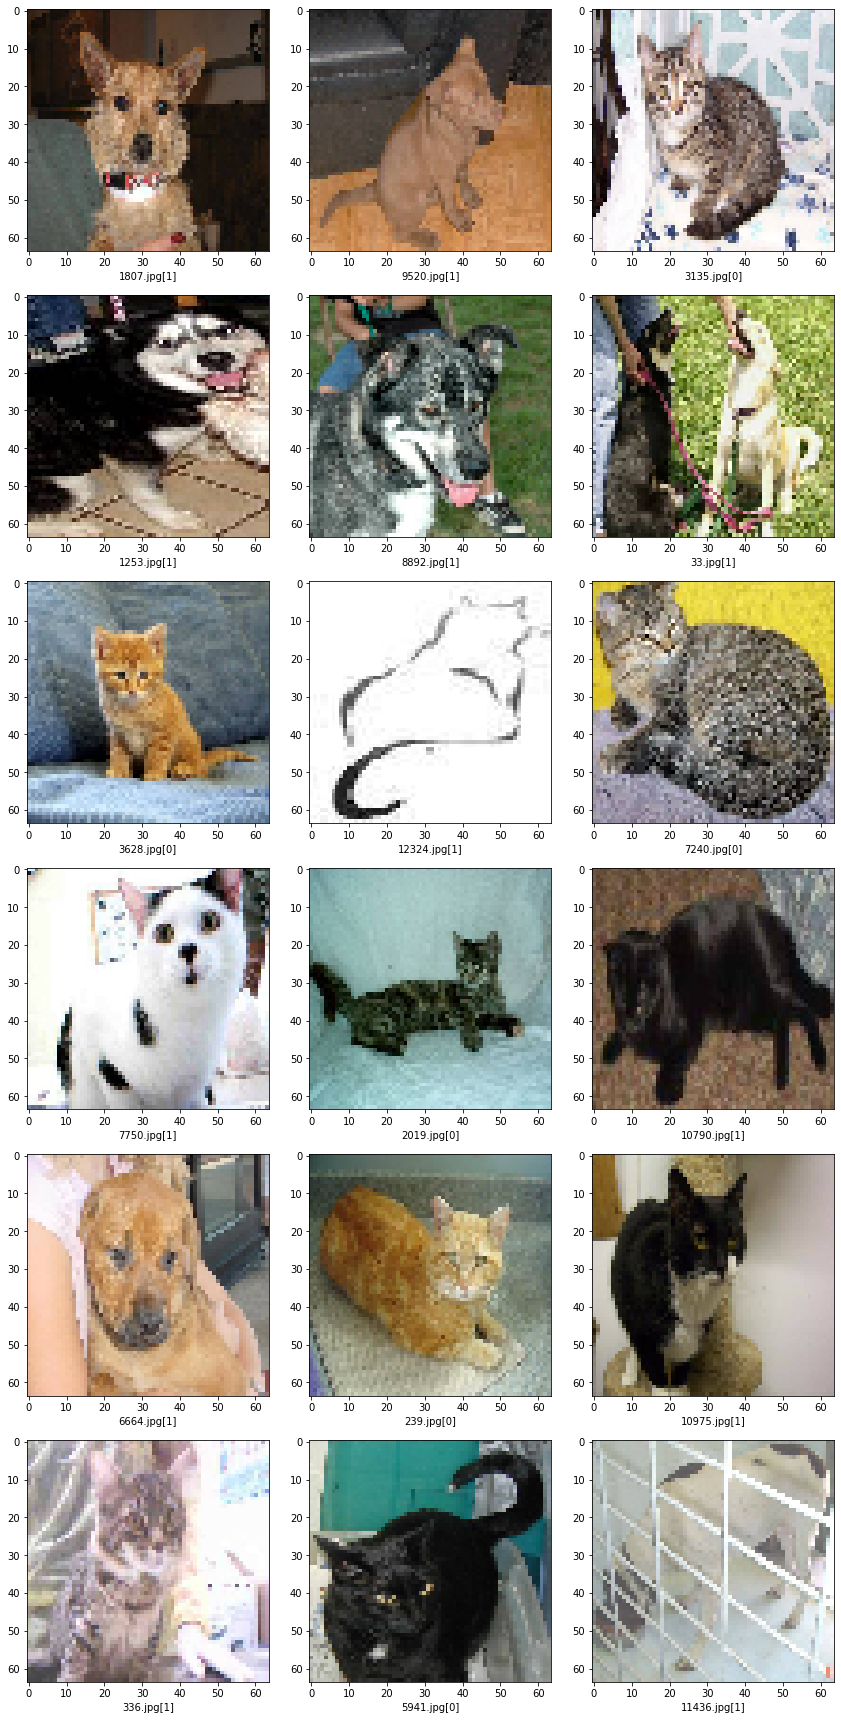

In [38]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('test1/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '[' + "{}".format(category) + ']' )
plt.tight_layout()
plt.show()